In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 65
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import statistics
import math
import warnings
import itertools
from statsmodels.tsa.api import Holt
from scipy.optimize import curve_fit
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
#simple linear regression
def CI_PI_simple_regression(x, y, x1, a):
    x_new = np.array([1, x1])
    print("make CI and PI predictions at mean of x = ", x1)
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core1 = (1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    core2 = (1 + 1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
    lower_bound2 = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
    upper_bound2 = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
    half_interval2 = t_plus * (result_reg.mse_resid ** 0.5) * core2
    print("confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI
def c_of_c_test(r, n):
    t_value = r * ((n-2)/(1 - r**2)) ** 0.5
    t_critical = stats.t.ppf(0.975, n - 2)
    pval = stats.t.sf(np.abs(t_value), n - 2)*2
    print('r = ', r)
    print('t_critical = ', t_critical)
    print('t = ', t_value)
    print('p_value = ', pval)
    return t_value

In [3]:
def Normality(SD):
    print('Normality test for errors using Shapiro Test')
    print(' - H0: Errors are normally distributed.')
    print(' - H1: Errors are not normally distributed.\n')
    stat, p = stats.shapiro(SD)
    print('pvalue of Shapiro Test =', p)
    if p < 0.05:
        print('\nSince p-value < 0.05, we reject H0 and conclude errors are not normally distributed.')
    else:
        print('\nSince p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
def Homoscedasticity(data, xlabel):
    print('Homoscedasticity Test')
    print(' - H0: Homoscedasticity')
    print(' - H1: Heteroscedasticity\n')
    y_pre = data[:, 2]
    SD = data[:, 10]
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(xlabel)
    plt.ylabel('Standardized Residual')
    plt.show()
def Randomness(SD):
    print('Randomness Test using Runs Test')
    print(' - H0: Randomness exists.')
    print(' - H1: Randomness does not exist\n')    
    SD_median = statistics.median(SD)    
    runs, n1, n2 = 1, 0, 0
    if(SD[0]) >= SD_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(len(SD)): 
        # no. of runs 
        if (SD[i] >= SD_median and SD[i-1] < SD_median) or (SD[i] < SD_median and SD[i-1] >= SD_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(SD[i]) >= SD_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    if n1>20 or n2>20:
        print('\nruns_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z)
        
        if pval_z < 0.05:
            print('\nSince p-value < 0.05, we reject H0 and conclude randomness does not exist.')
        else:
            print('\nSince p-value > 0.05, we do not reject H0 and we may conclude randomness exists.')
    else:
        print('Since both n1 and n2 < 20, we check the Run Test table.')
def Outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    ids = outliers.index
    ids = [n+1 for n in ids]
    
    print("Outliers by SD = \n")
    print(outliers)
    
    if len(ids)== 0:
        print("\nThere isnt any oulier.")
    else:
        print("\nSample", ids, "are outliers.")
def Influential(x_data, y_data):
    x_data = x_data.values
    y_data = y_data.values
    cov_mat = np.cov(y_data, x_data)
    x_data_bar = x_data.mean()
    data_nobs = len(x_data)
    h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat[1,1]
    df = pd.DataFrame(h_val,columns = ['hi'])
    filter = (df['hi'] > 6 / data_nobs )
    influs = df['hi'].loc[filter]
    ids = influs.index
    ids = [n+1 for n in ids]
    
    print("Influential Observations by hi = \n")
    print(influs)
    
    if len(ids)== 0:
        print("\nThere isn't any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")
def CI_PI_regression(xdata, yval, x1, a): #多變數的
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5

    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    
    CI = [lower_bound, upper_bound]
    PI = [lower_bound2, upper_bound2]
    return CI, PI

In [4]:
#multiple
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z
def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)
def Chi_Square_for_Normality(stand_res, N, a): 
    m = np.mean(stand_res)
    s = np.std(stand_res)
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s
    counts, bins = np.histogram(stand_res, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]   
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e)
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = freq_o.shape[0]-3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    
    return chi_pval

# simple Linear Regression

* Accessing the model: 
    - standard error of estimate-> if smaller than mean of y is good
    - see the r-squared
    - 斜率為0=這倆係數無關則無效
    - multiple reg時要看ANOVA F TEST

### 16-5 溫度與啤酒的關聯
X(independent variable) - Temperature<br>
y(dependent variable) - Beers(Beer Sales)

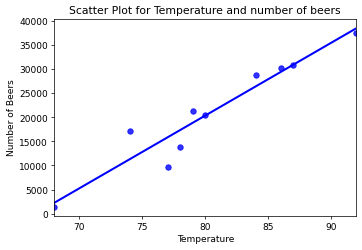

According to the scatter plot, we can see that there is linear relationship between Temperature and Number of Beers. Thus, we can apply Simple linear regression with OLS.
                            OLS Regression Results                            
Dep. Variable:                  Beers   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     80.61
Date:                Sun, 29 May 2022   Prob (F-statistic):           1.89e-05
Time:                        22:24:17   Log-Likelihood:                -94.740
No. Observations:                  10   AIC:                             193.5
Df Residuals:                       8   BIC:                             194.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err      

In [52]:
df16_5 = pd.read_excel('Xr16-05.xlsx')
_ = sns.regplot(x='Temperature', y= 'Beers', data = df16_5, color = 'b', ci = None)
plt.title('Scatter Plot for Temperature and number of beers')
plt.xlabel('Temperature')
plt.ylabel('Number of Beers')
plt.show()
print("According to the scatter plot, we can see that there is linear relationship between Temperature and Number of Beers. Thus, we can apply Simple linear regression with OLS.")
df16_result1 = smf.ols('Beers~ Temperature', data=df16_5).fit()
print(df16_result1.summary())
b1_1 = df16_result1.params[1]
b0_1 = df16_result1.params[0]
print("Estimated model: y = %0.4f + %0.4f x" % (b0_1, b1_1))
print("Interpretation: For each additional one degree increase in temperature the number of beers sold increases on average by 1513.3276. The y-intercept is the point at which the regression line hits the y–axis; it has no practical meaning.")
CI_PI_result = CI_PI_simple_regression(df16_5['Temperature'], df16_5['Beers'], 75, 0.1)
print(CI_PI_result)
#prediction是對於一個x，個別y點的估計比較易受其他因素影響，confidence是對於給x,y的平均比較準

#determine有沒有negative關聯：<br>
H0: β1 >= 0<br>
H1: β1 < 0<br>
According to the table. The pvalue is 1 - 0.000/2 = 1 > alpha = 0.05. Thus, we cannot reject the null hypothesis at a significance level of 0.05. There is no evidence of a negative linear relationship between temperature and the number of beers sold.<br>
#有無正向關係，<br>
H0:β1 <= 0<br>
H1:β1 > 0<br>
According to the table. The pvalue of **Temperature/2** = 0.000 < alpha = 0.05. Thus, we reject the null hypothesis at a significance level of 0.05. There is enough evidence to infer that there is a positive linear relationship between ...<br>
#解釋rsquared<br>
Acoording to the table, R-squared is 0.91. Therefore, 91% of the variation in beers is explained by the variation in temperature. The rest 9% remains unexplained by this model.<br>
#有無線性關係<br>
H0:  β1=0<br>
H1:  β1≠0<br>
The pvalue of Temperature = 0.000 < alpha = 0.05. Thus, we reject the null hypothesis at a significance level of 0.05. There is evidence of a linear relationship between .....

,Temperature,Beers,Predicted y,Residuals
0,80,20533,20388.036197,144.963803
1,68,1439,2228.104926,-789.104926
2,78,13829,17361.380985,-3532.380985
3,79,21286,18874.708591,2411.291409
4,87,30985,30981.329439,3.670561
5,74,17187,11308.070561,5878.929439
6,86,30240,29468.001833,771.998167
7,92,37596,38547.967468,-951.967468
8,77,9610,15848.053379,-6238.053379
9,84,28742,26441.346621,2300.653379


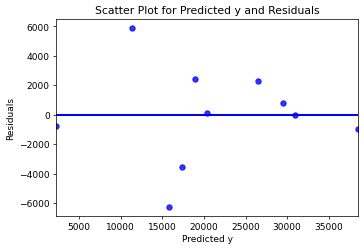

Outliers by SD = 

Series([], Name: SD, dtype: float64)

There isnt any oulier.
Influential Observations by hi = 

Series([], Name: hi, dtype: float64)

There isn't any influential observation.


In [53]:
#參考價值低
df16_5["Predicted y"] = b0_1 + b1_1 * df16_5["Temperature"]
df16_5["Residuals"] = df16_5["Beers"] - df16_5["Predicted y"] 
display(df16_5) #單變數預測，與尚未標準化的殘值
_ = sns.regplot(x='Predicted y', y= 'Residuals', data = df16_5, color = 'b', ci = None)
plt.title('Scatter Plot for Predicted y and Residuals')
plt.xlabel('Predicted y')
plt.ylabel('Residuals')
plt.show()
st5, data5, ss5 = sso.summary_table(df16_result1, alpha=0.05)
SD5 = data5[:, 10]
Outlier(SD5)
Influential(df16_5["Temperature"],df16_5["Beers"])

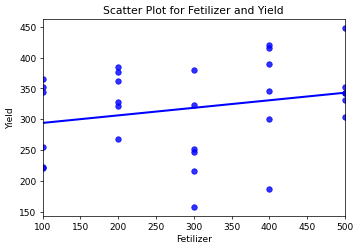

According to the scatter plot, it seems to be a little linear relationship between Yield and Fetilizer.


In [54]:
#完整的一次
df16_133 = pd.read_excel('Xr16-133.xlsx')
_ = sns.regplot(x='Fetilizer', y= 'Yield', data = df16_133, color = 'b', ci = None)
plt.title('Scatter Plot for Fetilizer and Yield')
plt.xlabel('Fetilizer')
plt.ylabel('Yield')
plt.show()
print("According to the scatter plot, it seems to be a little linear relationship between Yield and Fetilizer.")

In [55]:
df16_result3 = smf.ols('Yield~ Fetilizer', data=df16_133).fit()
print(df16_result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.772
Date:                Sun, 29 May 2022   Prob (F-statistic):              0.194
Time:                        22:24:18   Log-Likelihood:                -169.57
No. Observations:                  30   AIC:                             343.1
Df Residuals:                      28   BIC:                             345.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    281.8000     30.561      9.221      0.0

In [56]:
b1_1 = df16_result3.params[1]
b0_1 = df16_result3.params[0]
print("Estimated model: y = %0.4f + %0.4f x" % (b0_1, b1_1))

Estimated model: y = 281.8000 + 0.1227 x


Interpretation<br>
The slope is .123, which tells us that for each additional unit of fertilizer, corn yield increases on average by .123. The y-intercept is 281.7, which has no real meaning.<br>
H0: β1 = 0<br>
H1: β1 != 0<br>
According to the table. The pvalue is 0.194 > alpha = 0.05.<br>
Thus, we cannot reject the null hypothesis at a significance level of 0.05.<br>
There is no evidence of a linear relationship between Fertilizer and Yield.<br>
r squared=0.06, 6% of the variation in corn yield is explained by the variation in amount of fertilizer.<br>
The model is too poor to be used to predict. (原因合理即可，eg (c)R square太低、(b)非線性)

Normality test for errors using Shapiro Test
 - H0: Errors are normally distributed.
 - H1: Errors are not normally distributed.

pvalue of Shapiro Test = 0.2068082094192505

Since p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.
Homoscedasticity Test
 - H0: Homoscedasticity
 - H1: Heteroscedasticity



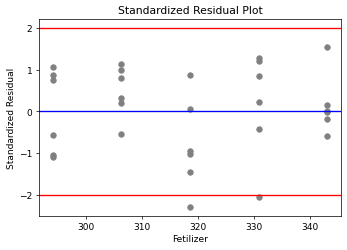

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  19
n1 =  15
n2 =  16
Since both n1 and n2 < 20, we check the Run Test table.


In [57]:
#Residual analysis
st133, data133, ss133 = sso.summary_table(df16_result3, alpha=0.05)
SD133 = data133[:, 10]
Normality(SD133)
Homoscedasticity(data133, "Fetilizer") #測試肥料(x)有無隨著大小特定變化
Randomness(SD133)

After checking the Run Test table, we reject H0 if runs <= 10 or runs >=23.<br>
Since 10 < runs = 19 < 23, we do not reject H0 and we may conclude Randomness exists.

# multiple 

1. Plot the scatter diagram
2. Propose a statistical model
3. Fit the model
4. Regression Diagnostics (multicollinearity and autocorrelation)
5. Residual analysis
6. Assess the fitted model
7. Interpretation
8. Apply for prediction.

In [58]:
df17_1 = pd.read_excel('Xr17-01.xlsx')
display(df17_1.head())
#Independent variable:
#X1: Lot size
#x2: Trees
#x3: Distance
#Dependent variable (y): Price

,Price,Lot size,Trees,Distance
0,105.4,41.2,24,42
1,91.2,44.8,5,71
2,183.3,21.3,72,43
3,93.8,43.9,58,14
4,207.5,57.7,52,12


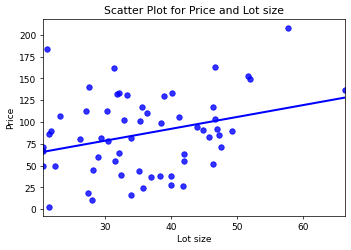

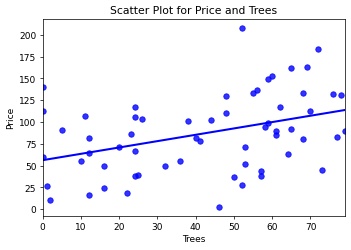

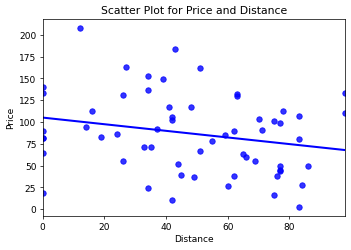

According to the scatter plot, all independet variables seem to have linear relationship with Price.


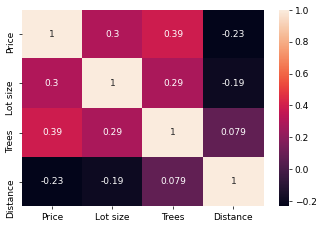

In [59]:
y_var = df17_1['Price'].values
xnames = df17_1.columns[1:]
for aname in xnames:
    x_var = df17_1[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df17_1, color = 'b', ci = None)
    plt.xlabel(aname)
    plt.ylabel('Price')
    plt.title('Scatter Plot for Price and ' +aname)
    plt.show()
print("According to the scatter plot, all independent variables seem to have linear relationship with Price.")
df17_1a = df17_1[df17_1.columns]
corr1 = df17_1a.corr()
_ = sns.heatmap(corr1, annot=True)

In [60]:
y_data = df17_1['Price']
X_data_ar = np.array([df17_1['Lot size'], df17_1['Trees'], df17_1['Distance']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df17_1.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())
b1_3 = result_reg.params[3]
b1_2 = result_reg.params[2]
b1_1 = result_reg.params[1]
b0_1 = result_reg.params[0]
print("Estimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0_1, b1_1, b1_2, b1_3))
print("standard error = ", result_reg.mse_resid ** 0.5)#It is an estimate of the standard deviation of the error variable.
r2 = result_reg.rsquared
print("r^2 = ", r2)#24%能被解釋
r2_adj = result_reg.rsquared_adj
print("adjusted r^2 = ", r2_adj)#It differs because it includes an adjustment for the number of independent variables


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     5.975
Date:                Sun, 29 May 2022   Prob (F-statistic):            0.00132
Time:                        22:24:19   Log-Likelihood:                -304.76
No. Observations:                  60   AIC:                             617.5
Df Residuals:                      56   BIC:                             625.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3912     23.517      2.185      0.0

H0: beta_1 = beta_2 = beta_3 = 0<br>
H1: At least one of the betas != 0<br>
Since p-value for the F-test is 0.00132 < alpha = 0.05, we can reject H0.
There is enough evidence to conclude that the model is valid.<br>
#interpret:<br>
b1 = .700; for each addition thousand square feet the price on average increases by .700 thousand dollars provided that the other variables remain constant.<br>
b2 = .679; for each addition tree the price on average increases by .679 thousand dollars provided that the other variables remain constant.<br>
b3 = –.378; for each addition foot from the lake the price on average decreases by .378 thousand dollars provided that the other variables remain constant.<br>
**Test whether each of the independent variables is linearly related to the price of the lot in this model.**<br>
H0: βi = 0 for i = 1, 2, 3<br>
H1: βi ≠ 0 for i = 1, 2, 3<br>
According to the OLS Regression Results Summary Table,<br>
i = 1: pvalue of lot size = 0.216 > 0.05. We do not reject H0.<br>
i = 2: pvalue of Trees = 0.004 < 0.05. We reject H0.<br>
i = 3: pvalue of Distance = 0.058 > 0.05. We do not reject H0.<br>
Thus, only for the number of trees is there enough evidence to infer a linear relationship with price.

In [61]:
#Predict with 90% confidence the selling price of a 40,000-square-foot lot that has 50 mature
#trees and is 25 feet from the lake.
x1 = [1,40,50,25]
CI, PI = CI_PI_regression(X_data_ar, y_data, x1, 0.1)
print("Predicted sell = ", PI, "(thousand dollar)") #問CI則改CI

Predicted sell =  [35.49789014478607, 172.2401711730186] (thousand dollar)


### Residual analysis

Normality test for errors using Shapiro Test
 - H0: Errors are normally distributed.
 - H1: Errors are not normally distributed.

pvalue of Shapiro Test = 0.14052797853946686

Since p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.
Homoscedasticity Test
 - H0: Homoscedasticity
 - H1: Heteroscedasticity



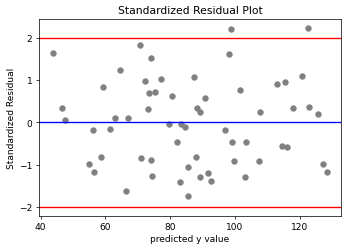

We do not reject H0. We can assume the variation is constant and the mean is around 0.
Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  29
n1 =  31
n2 =  30

runs_exp =  31.491803278688526
stan_dev =  3.8713870552803846
z =  -0.6436461255636597
pval_z =  0.5198049325468987

Since p-value > 0.05, we do not reject H0 and we may conclude randomness exists.
Outliers by SD = 

2    2.227621
4    2.238522
Name: SD, dtype: float64

Sample [3, 5] are outliers.
Method 1:
h_level =  0.2
Influential Observations by hi = 
Series([], Name: hii, dtype: float64)

Method 2:
Influential Observations by Cook's Distances = 
Series([], Name: CD, dtype: float64)


In [62]:
st, data, ss2 = sso.summary_table(result_reg, alpha=0.05)
y_pre = data[:, 2]
SD = data[:, 10]
Normality(SD)
Homoscedasticity(data,"predicted y value") #後面是xlabel隨便打
print("We do not reject H0. We can assume the variation is constant and the mean is around 0.")
Randomness(SD)
Outlier(SD)
#influ比較麻煩
print("Method 1:")
X_data2 = np.array(X_data2)
H = np.matmul(X_data2, np.linalg.solve(np.matmul(X_data2.T, X_data2), X_data2.T))
df17_1['hii'] = np.diagonal(H)
df_h = pd.DataFrame(df17_1['hii'])
k = result_reg.df_model
n = len(df_h['hii'])
h_level = 3 * (k+1) / n 
print("h_level = ", h_level)
filter = (df_h['hii'] > h_level )
print("Influential Observations by hi = ")
print(df_h['hii'].loc[filter])

print("\nMethod 2:")
s2_e = result_reg.mse_resid
k = result_reg.df_model
y_a = data[:, 1]
y_f = data[:, 2]
h_i = df17_1['hii']
CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * h_i / np.square(1 - h_i)
CD = np.array(CD_arr)
df_cd = pd.DataFrame(CD,columns = ['CD'])
# display(df_cd.head())
filter = (df_cd['CD'] > 1 )
print("Influential Observations by Cook's Distances = ")
print(df_cd['CD'].loc[filter])

In [64]:
# multicollinearity :
# 1.變數間相關係數有無超過0.7
# 2.若Ｆ拒絕卻無任何一係數之Ｔ能拒絕
# 3.coefficient正負號

### regression diagnostics
#multicollinearity<br>
There is no correlation between variables bigger than 0.7 or smaller than -0.7.<br>
The outcome of F-test and t-test are consistent.<br>
The signs of the variable coefficients in the model are same as the correlation coefficients in heatmap.<br>
Therefore, multicollinearity doesn't exist.<br>
#Autocorreltaion<br>
H0: The data are not first-order correlated<br>
H1: The data are first-order correlated

In [65]:
d_w = Durbin_Watson_test(SD)
print(d_w)
#此題三個x變因，k=4, T=標本數=60去查，5%的一半為2.5%的表因為是two-tail test

x_square_sum =  60.38903386965764
size =  60
x_d =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_d =  [ 0.          0.21681114  1.38392769 -2.79995485  2.81085547 -1.90028362
  1.2898011  -3.37066134  1.63935944 -1.19231335  0.37848942  0.09271198
  1.15158396  0.65913125 -1.4549664   0.43194036 -0.78540052  0.92524969
  0.60184696 -0.50422216  0.82231958 -0.96715857 -0.22734985 -1.00176246
  0.70935147  1.41420182  0.29749328 -2.642224    2.47192084 -1.95816729
  0.84323978 -1.22684923  1.60330381 -0.09030467  0.66873659 -0.5667618
 -1.41310771  1.63875129 -1.41039343 -0.15840714 -0.64014695  1.4871501
 -0.04321562  0.5480084  -1.57136746  0.28985031  2.01473851 -1.55956789
  0.70686754  1.59423674 -2.40441221  0.66563424 -1.08613913  1.77225212
 -1.94995537 -0.23565564  2.13612725  0.91108422 -2.94849982  2.83701611]
d =  2.1650567787398325
2.16

dL=1.4035, dU=1.6104<br>
Because 2 < 2.165056778739832 < 2.3896 = 4-1.6104, there is not enough evidence to infer that first order auto-correlation exists

# autocorrelation的要如何重做

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     19.09
Date:                Sun, 29 May 2022   Prob (F-statistic):           1.02e-07
Time:                        22:40:15   Log-Likelihood:                -725.80
No. Observations:                 100   AIC:                             1458.
Df Residuals:                      97   BIC:                             1465.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    303.2529    212.868      1.425      0.1

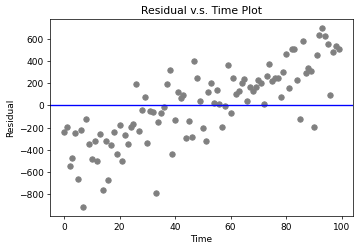

By the graph above, autocorrelation seem to exist.


In [71]:
df = pd.read_excel('Xr17-53.xlsx')
result_reg = smf.ols('Y~ X1 + X2', data=df).fit()
print(result.summary())
b2_1 = result_reg.params[2]
b1_1 = result_reg.params[1]
b0_1 = result_reg.params[0]
corr = df.corr()
st, data, ss2 = sso.summary_table(result_reg, alpha=0.1)
y_pre = data[:, 2]
SD = data[:, 10]
plt.plot(df.index, data[:, 8], 'o', color = 'gray')
plt.title('Residual v.s. Time Plot')
plt.axhline(y=0, color = 'blue')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()
print("By the graph above, autocorrelation seem to exist.")

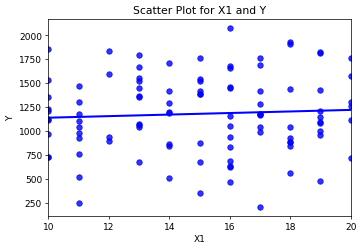

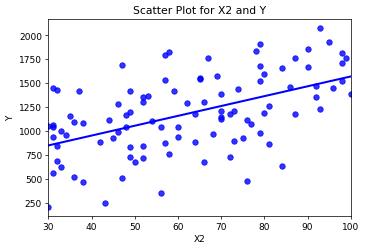

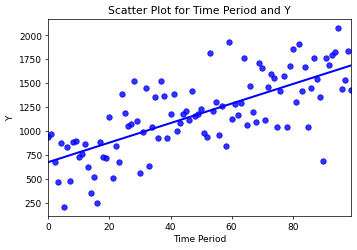

In [9]:
#重做版本 全過程都有
df = pd.read_excel('Xr17-53.xlsx')
df['Period']=df.index
_ = sns.regplot(x='X1', y= 'Y', data = df, color = 'b', ci = None)
plt.title('Scatter Plot for X1 and Y')
plt.xlabel('X1')
plt.ylabel('Y')
plt.show()
_ = sns.regplot(x='X2', y= 'Y', data = df, color = 'b', ci = None)
plt.title('Scatter Plot for X2 and Y')
plt.xlabel('X2')
plt.ylabel('Y')
plt.show()
_ = sns.regplot(x='Period', y= 'Y', data = df, color = 'b', ci = None)
plt.title('Scatter Plot for Time Period and Y')
plt.xlabel('Time Period')
plt.ylabel('Y')
plt.show()

According to the scatter plot, we can see that there are linear relationships between X1 and Y, X2 and Y, and Period and Y.
Thus, we can apply Multiple linear regression with OLS.<br>
Propose a statistical model: y=b0+b1*x1+b2*x2+b3*period+e<br>

In [10]:
y = df['Y']
X_ar = np.array([df['X1'], df['X2'], df['Period']])
X_T =X_ar.T
xnames = ['X1', 'X2', 'Period']
X = pd.DataFrame(X_T,columns = xnames)
X = sm.add_constant(X)
olsmod = sm.OLS(y, X)
result_reg = olsmod.fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     94.55
Date:                Sun, 29 May 2022   Prob (F-statistic):           1.49e-28
Time:                        22:53:26   Log-Likelihood:                -673.65
No. Observations:                 100   AIC:                             1355.
Df Residuals:                      96   BIC:                             1366.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6437    128.803      0.153      0.8

### regression diagnostics
#### multicollinearity

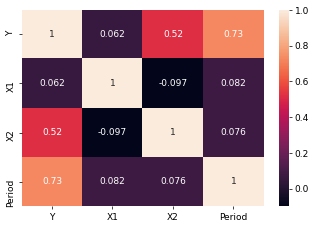

In [11]:
corr = df.corr()
_ = sns.heatmap(corr, annot=True)

There is no correlation between variables bigger than 0.7 or smaller than -0.7.
The outcome of F-test and t-test are consistent.
The signs of the variable coefficients in the model are same as the correlation coefficients in heatmap.
Therefore, multicollinearity doesn't exist.<br>
#### Autocorreltaion
H0: The data are not first-order correlated<br>
H1: The data are first-order correlated

In [12]:
st, data, ss2 = sso.summary_table(result_reg, alpha=0.1) #注意此題的alpha=0.1
y_pre = data[:, 2]
SD = data[:, 10]
d_w = Durbin_Watson_test(SD)
print(d_w)

x_square_sum =  99.97386328649371
size =  100
x_d =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
x_d =  [ 0.         -0.00724353 -1.58622858  0.18007596  1.13208962 -2.17419147
  2.18447088 -3.1726906   3.62055431 -1.23477932 -0.79294612  0.71979368
 -0.65915185  0.92523052 -2.41506929  1.82595681 -1.71857721  1.88217469
  0.14803548 -0.59490872  1.29695234 -1.97451107  1.25770206 -0.62309347
  1.0647745  -0.07750362  1.53506758 -2.0044474   1.1030932   0.09291912
 -1.92787558  1.41686448  0.04064547 -3.57670407  2.98566529  0.25810382
 -0.00785933  1.23275654  0.39423397 -3.38068369  1.37583504  1.10126275
 -0.36137125  0.11313661 -1.7383296   0.67407832 -0.70269912  2.8969867
 -0.75306104 -1.10902891 -1.11456341 -0.65267994  1

dL=1.613, dU=1.736<br>
Because 2 < 2.1259112181628956 < 2.264 = 4-dU, there is not enough evidence to infer that first order autocorrelation exists.

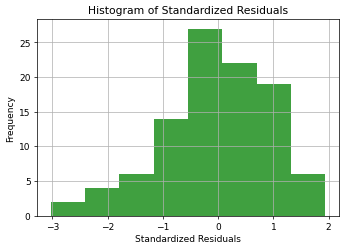

Normality test for errors using Shapiro Test
 - H0: Errors are normally distributed.
 - H1: Errors are not normally distributed.

pvalue of Shapiro Test = 0.025478344410657883

Since p-value < 0.05, we reject H0 and conclude errors are not normally distributed.
Homoscedasticity Test
 - H0: Homoscedasticity
 - H1: Heteroscedasticity



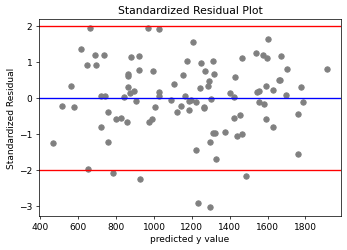

We do not reject H0. We can assume the variation is constant and the mean is around 0.
Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  51
n1 =  51
n2 =  50

runs_exp =  51.495049504950494
stan_dev =  4.999254919487954
z =  -0.09902465725856582
pval_z =  0.9211186926579791

Since p-value > 0.05, we do not reject H0 and we may conclude randomness exists.
Outliers by SD = 

7    -2.252888
14   -2.089256
33   -2.922691
85   -2.180681
90   -3.028743
Name: SD, dtype: float64

Sample [8, 15, 34, 86, 91] are outliers.
Method 1:
h_level =  0.12
Influential Observations by hi = 
Series([], Name: hii, dtype: float64)
Autal ID:  Int64Index([], dtype='int64')

Method 2:
Influential Observations by Cook's Distances = 
Series([], Name: CD, dtype: float64)


In [15]:
fig, ax = plt.subplots()
counts, bins, patches = plt.hist(SD, 8, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals')
plt.grid(True)
bin_centers = [np.mean(k_1) for k_1 in zip(bins[:-1], bins[1:])]
plt.show()

Normality(SD)
Homoscedasticity(data,"predicted y value") #後面是xlabel隨便打
print("We do not reject H0. We can assume the variation is constant and the mean is around 0.")
Randomness(SD)
Outlier(SD)
#influ比較麻煩
print("Method 1:")
X = np.array(X)
H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
df['hii'] = np.diagonal(H)
df_h = pd.DataFrame(df['hii'])
k = result_reg.df_model
n = len(df_h['hii'])
h_level = 3 * (k+1) / n 
print("h_level = ", h_level)
filter = (df_h['hii'] > h_level )
print("Influential Observations by hi = ")
print(df_h['hii'].loc[filter])
print("Autal ID: ",df_h['hii'].loc[filter].index+1)

print("\nMethod 2:")
s2_e = result_reg.mse_resid
k = result_reg.df_model
y_a = data[:, 1]
y_f = data[:, 2]
h_i = df['hii']
CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * h_i / np.square(1 - h_i)
CD = np.array(CD_arr)
df_cd = pd.DataFrame(CD,columns = ['CD'])
filter = (df_cd['CD'] > 1 )
print("Influential Observations by Cook's Distances = ")
print(df_cd['CD'].loc[filter])

### Assess the fitted model
#### Standard Error of Estimate

In [17]:
print("standard error = ", result_reg.mse_resid ** 0.5)
print("mean of y =", df['Y'].mean())
print("std of y =", df['Y'].std())

standard error =  208.08604426846517
mean of y = 1180.25
std of y = 407.4925140292751


SE appears to be relatively “small” (compared to 1180.25), hence the regression model is “good”.<br>
#### R and R_Squared
From the output table above, we can get r2 = 0.747. 74.7% of the variation in Y is explained by this regression line of the three independent variables and 25.3% remains unexplained.<br>
Besides, ra2 = 0.739 is very close to 0.747, which indicating that the model has not problem of over-fitting.<br>
#### F-test
H0: β_1 = β_2 = β_3 = 0<br>
H1: At least one of the parameters is not equal to zero.<br>
the p-value for F-test is smaller than alpha=0.05, so we can reject H0. At least one β_i is not equal to zero, the model has some validity.<br>
#### Testing of the Coefficients
H0: β_i=0<br>
H1: β_i≠0<br>
From the output table above, p-value of β2 and p-value of β3 are smaller than 0.05, so we can reject H0.
Therefore, we can infer that X2 and time period are linearly related to Y.
### Interpretation
Model: y = 19.6437 + X1 6.7805 + X2 9.3716 + Period * 9.6413<br>
b0=19.6437: This is the intercept, the value of y when all the variables take the value zero. Since the data range of all the independent variables do not cover the value zero, do not interpret the intercept.<br>
b1=6.7805: In this model, for each additional X1, Y would increase 6.7805. (assuming the other variables are held constant).<br>
b2=9.3716: In this model, for each additional X2, Y would increase 9.3716. (assuming the other variables are held constant).<Br>
b3=9.6413: In this model, for each additional time period, Y would decrease 9.6413.(assuming the other variables are held constant).